In [150]:
import time
import os
import glob
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

In [133]:
# Define run parmameters

transform_image_size = 224

batch_size = 8

num_epochs = 2

In [134]:
# Data dict

data_directory = "./dataset2/dorsal"

In [135]:
# Check device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [136]:
# Increase number of unique images by factor of 2 by horizontal flipping,
# but cant vertically flip

# Change colour channels from 0-255 to 0-1, numpy to tensors

train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(transform_image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], # col = rgb channel
        [0.229, 0.224, 0.225]) # row = mean deviation
])

valid_transformation = transforms.Compose([
        transforms.Resize(transform_image_size),
        transforms.CenterCrop(transform_image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225])
])

In [137]:
# Datasets

train_dataset = datasets.ImageFolder(os.path.join(data_directory, 'train'), train_transformation)
valid_dataset = datasets.ImageFolder(os.path.join(data_directory, 'valid'), valid_transformation)

# Dataloader

train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # Shuffle is True so the model is not biased to some categories
    num_workers=4 # How many sub processes to use for loading data into ram
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers=4
)

In [138]:
train_root = pathlib.Path(data_directory + '/train')
data_classes = sorted([item.name.split('/')[-1] for item in train_root.iterdir()])
num_classes = len(data_classes)

In [139]:
print(data_classes)

['female', 'male']


In [140]:
# CNN Network

input_channels = 512
output_channels = num_classes # set to the number of data classes, eg: 2 (male and female)
kernal_size = (1,1)
stride = (1,1)

conv_network = models.squeezenet1_0(True)
for parameter in conv_network.parameters():
            parameter.requires_grad = False
conv_network.classifier[1] = nn.Conv2d(input_channels, output_channels, kernel_size = kernal_size, stride = stride)
conv_network.num_classes = num_classes

In [141]:
model = conv_network.to(device)
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [142]:
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
optimiser = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [143]:
# Calc amount of training and validation images for each class

train_male = len(glob.glob(data_directory + '/train/male/*.jpg'))
train_female = len(glob.glob(data_directory + '/train/female/*.jpg'))
train_count = train_male + train_female

valid_male = len(glob.glob(data_directory + '/valid/male/*.jpg'))
valid_female = len(glob.glob(data_directory + '/valid/female/*.jpg'))
valid_count = valid_male + valid_female

print('train male:', train_male, '\ttrain female:', train_female, '\ttrain count:', train_count)
print('valid male:', valid_male, '\tvalid female:', valid_female, '\tvalid count:', valid_count)

train male: 1493 	train female: 3000 	train count: 4493
valid male: 463 	valid female: 724 	valid count: 1187


In [144]:
def run_phase(phase_type, phase_count, phase_dataloader):
    since = time.time()
    phase_accuracy = 0.0
    phase_loss = 0.0
    # image_count = 0

    for images, labels in phase_dataloader:
        inputs = images.to(device)
        labels = labels.to(device)

        optimiser.zero_grad() # Zero out gradients when starting the training loop,
                              # else gradient will point away from objective direction

        with torch.set_grad_enabled(phase_type == 'train'):
            # Forward
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            _, prediction = torch.max(outputs, 1)

            if phase_type == 'train':
                # Backward
                loss.backward()
                optimiser.step()

        # Calc stats
        phase_accuracy = phase_accuracy + (torch.sum(prediction == labels.data))
        phase_loss = phase_loss + (loss.item() * images.size(0))

        # Update image counter and elpased time
        # time_elapsed = time.time() - since
        # time_min = time_elapsed // 60
        # time_sec = time_elapsed % 60
        # print('\r' + 'Image: ' + str(image_count), '\tElpased Time:', '{:.0f}m {:.0f}s'.format(time_min, time_sec), end='')
        # image_count+=1

    epoch_accuracy = phase_accuracy.double() / phase_count
    epoch_loss = phase_loss / phase_count

    time_elapsed = time.time() - since
    time_min = time_elapsed // 60
    time_sec = time_elapsed % 60
    
    print('\n{} \tLoss: {:.4f} \tAcc: {:.4f} \tElpased Time: {:.0f}m {:.0f}s'.format(phase_type, epoch_loss, epoch_accuracy, time_min, time_sec ))
    
    return epoch_accuracy

In [145]:
# Model training
def train(model, train_dataloader, valid_dataloader, optimiser, num_epochs):
    best_acc = 0.0
    epoch_accuracies = []
    best_model = copy.deepcopy(model.state_dict())
    since = time.time()

    for epoch in range(num_epochs):

        print('Epoch', str(epoch + 1) + '/' + str(num_epochs))

        # Train model phase
        model.train()
        run_phase('train', train_count, train_dataloader)

        # Eval model phase
        model.eval()
        epoch_acc = run_phase('valid', valid_count, valid_dataloader)
        
        # Check performace
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
            
        # Record performance for analysis
        epoch_accuracies.append(epoch_acc)

        print('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(best_acc)
    
    return best_model, epoch_accuracies

In [146]:
model, epoch_accuracies = train(model, train_dataloader, valid_dataloader, optimiser, num_epochs)

Epoch 1/2

train 	Loss: 0.3976 	Acc: 0.8302 	Elpased Time: 3m 18s

valid 	Loss: 0.4141 	Acc: 0.8180 	Elpased Time: 1m 5s


Epoch 2/2

train 	Loss: 0.3216 	Acc: 0.8691 	Elpased Time: 3m 14s

valid 	Loss: 0.3193 	Acc: 0.8804 	Elpased Time: 1m 7s


Training complete in 8m 44s
tensor(0.8804, dtype=torch.float64)


In [147]:
torch.save(model, 'trained_model.pt')

In [148]:
history = [h.cpu().numpy() for h in epoch_accuracies]

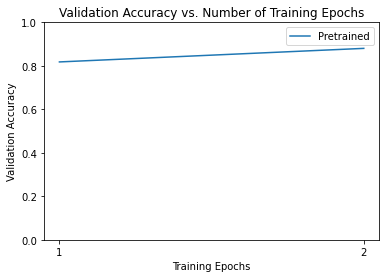

In [153]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),history,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()